In [1]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum

from IPython.display import clear_output
clear_output()

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [3]:
%cd '/content/drive/MyDrive/Projects/GSoC 2021'

/content/drive/MyDrive/Projects/GSoC 2021


# Task II: Quantum Generative Adversarial Network (QGAN) Part

Problem statement: You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC).

## The Approach Used to Tackle the Problem

### Dataset

The dataset consists of 100 samples, both for the training set and testing set. The label consists of two classes, background events are labeled as 0 and signal events are labeled as 1. Since there is no additional information about the dataset, all 5 features of the sample will be used for training.

### QGAN Architecture

The main purpose of this project is to separate the signal events from the background events, so the goal here is to train the discriminator until it becomes a good classifier, rather than creating a high-quality generator.

A previous recent related work has tried to do similar things but by using a hybrid architecture, they called it a quantum semi-supervised generative adversarial network (qSGAN)[1]. In qSGAN, a parametrized quantum circuit (PQC) is used as the generator, while a double-headed classical fully connected neural network is used as the discriminator. The discriminator here needs to do two tasks at once, classify the data into the correct label and determine whether the data is real or fake (from the generator).

In this project, a similar approach like qSGAN is used. Instead of using a classical neural network for the discriminator, a PQC will be used to both classify the data into the correct label and determine whether the data is real or fake. A "fully quantum" QGAN approach has been done before in reference [2] but the main goal of the paper is to create a good generator instead of to train a good discriminator as a classifier. We could say that this project try to take ideas from both papers and put them together to try to answer the problem statement.

#### Quantum Real Data

The real dataset is converted to quantum state by using angle encoding. Every sample is encoded into quantum state by treating the value of its features as angles for RY gates that act on |00..00⟩ qubits. Because there are 5 features in total for every sample, we need 5 qubits with an RY gate on every qubit to encode this data.

#### Quantum Discriminator

The quantum discriminator (qdisc) consists of 8 qubits. The first 5 qubits are the data qubits, where the quantum data circuit will be connected to qdisc. The last 3 qubits are the output qubits, where the first two outputs are considered as the class prediction [$C_{0}$, $C_{1}$] ([1, -1] for label 0 and [-1, 1] for label 1) and the last output is considered as the real/fake prediction [$D$] (1 for real and -1 for fake).

A Hadamard gate is applied to every data qubit, then several one-qubit unitaries and CNOT gates that entangled nearby qubits are then applied to all qubits. These one-qubit unitaries and CNOT gates can be repeated for several layers. At the end of the circuit, a final one-qubit unitary gate is applied to every output qubit. All output qubits are measured by using Pauli-Z gate. This construction of qdisc circuit is inspired by reference [1]. The complete picture/plot of qdisc circuit will be given in the **Code Implementation** section.

The qdisc circuit will be trained by using both quantum real data and quantum fake data. Quantum real data comes from the angle encoding circuit that uses real data for its angle, while quantum fake data comes from the quantum generator (qgen) circuit, discussed in the next section. See **Figure 1** and **Figure 2** for the schematics of these circuit architectures.

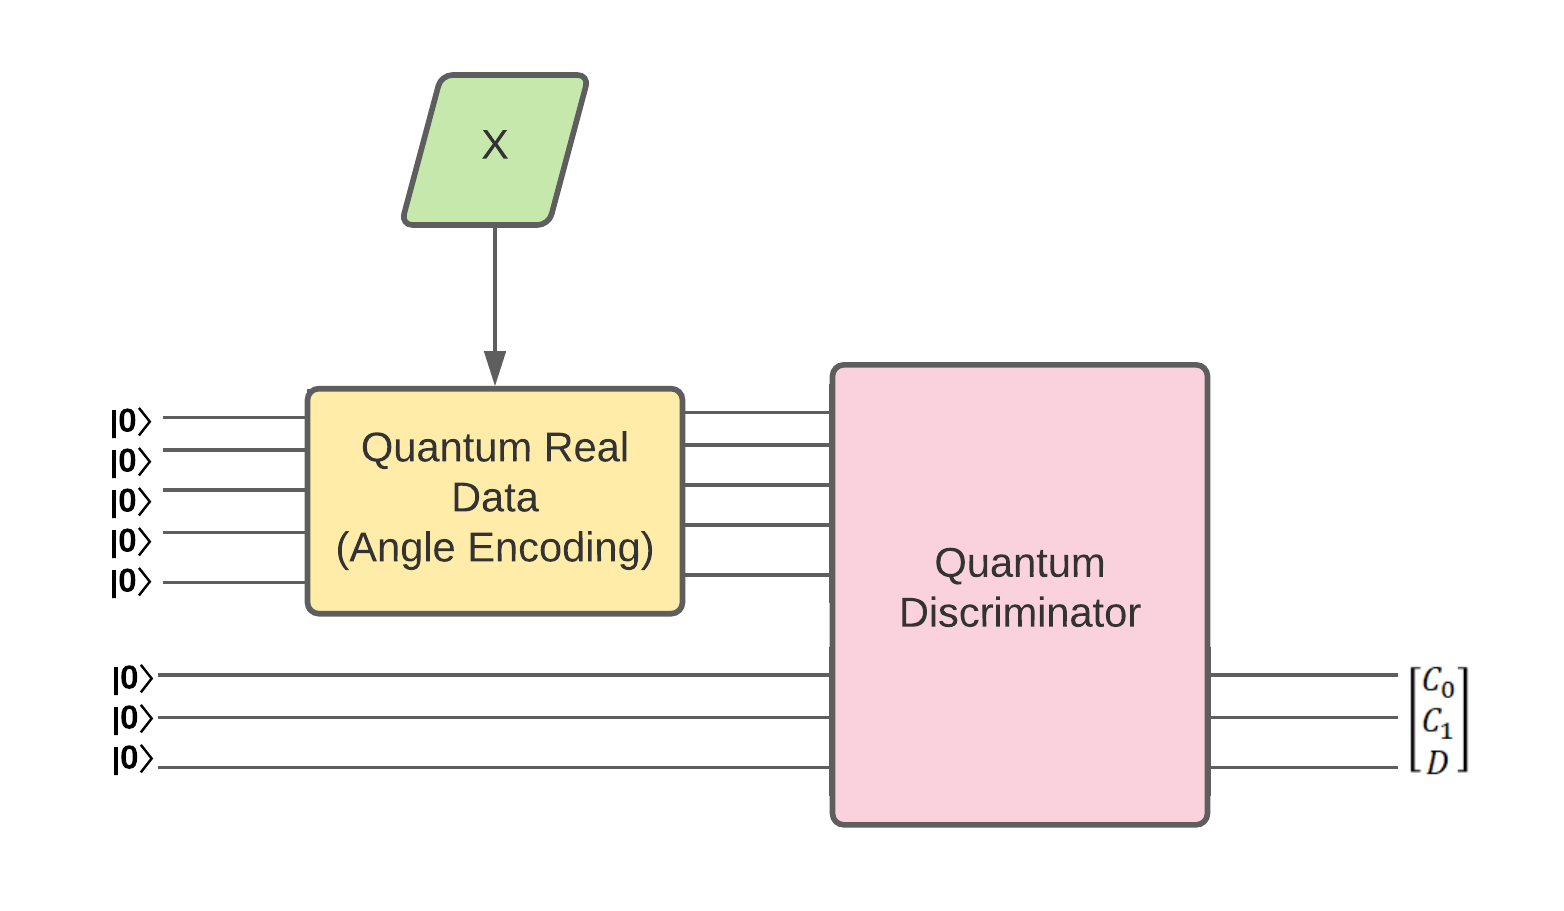

**Figure 1**: Quantum Discriminator schematic when connected to real quantum data. X is the sample from dataset.

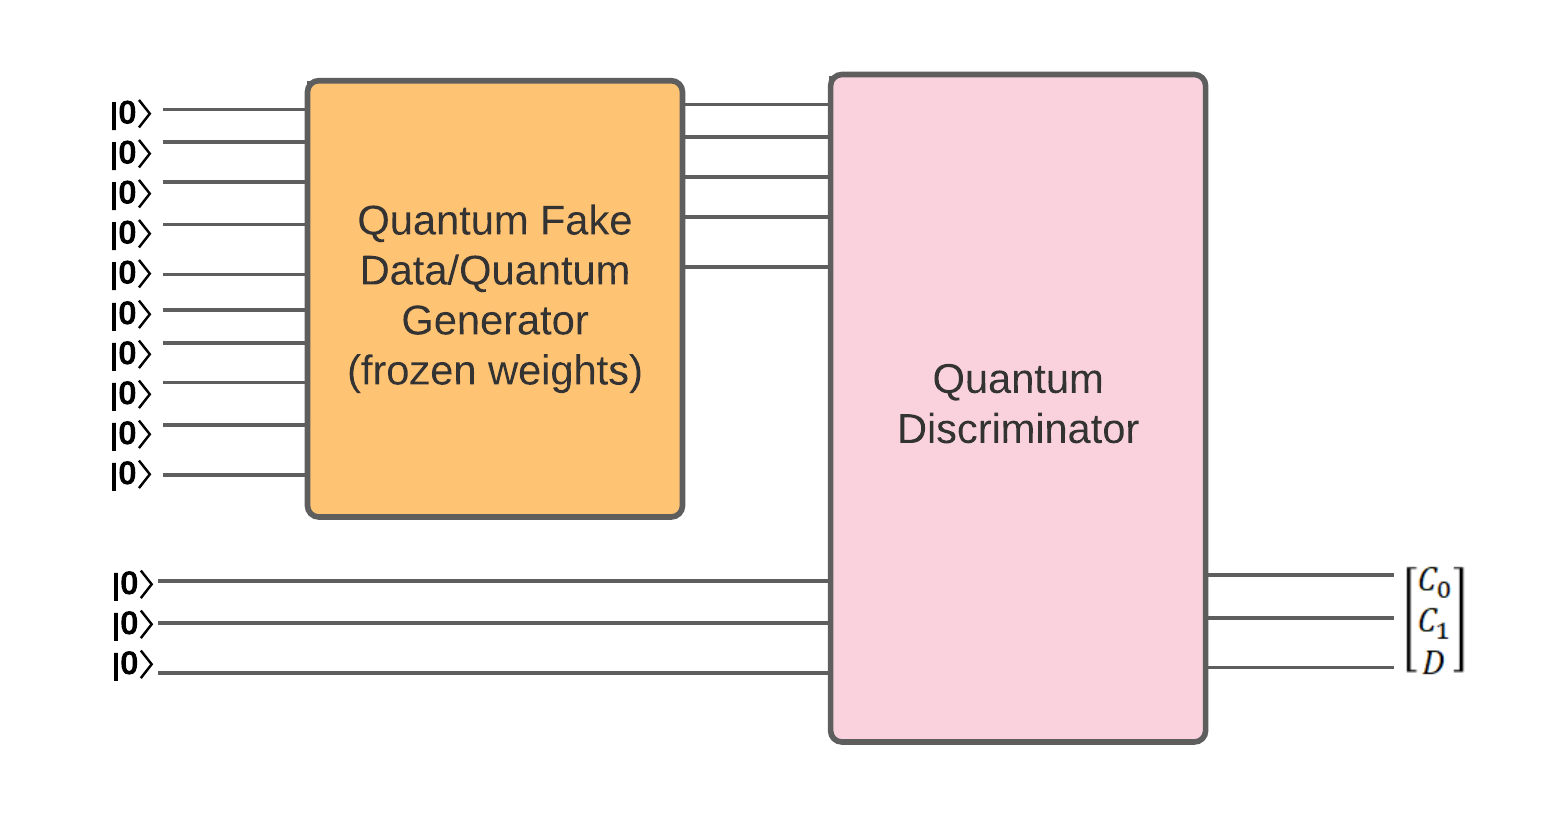

**Figure 2**: Quantum Discriminator schematic when connected to fake quantum data (quantum generator).

During discriminator training, only weights in the qdisc will be trained, while the weights in the qgen will be frozen. The reverse is true for generator training.

For training the discriminator, a mix of classification loss and fake/real loss will be used. The equations to calculate the loss value for one batch of training is as follow:

$$
L_{D}=-\frac{1}{m_{\text{fake}} + m_{\text{real}}} \left( \sum_{i=1}^{m_{\text{fake}}}\log \left(1-D\left(\boldsymbol{x}_{\text {fake}}^{i}\right)\right)+\sum_{i=j}^{m_{\text{real}}}\log D\left(\boldsymbol{x}_{\text {real}}^{j}\right)\right)
$$

where $m_{\text{fake}}$ and $m_{\text{real}}$ are the total number of fake and real data in the batch respectively, $D$ is the fake/real prediction from the qdisc.

$$
L_{C}= H(y_{true}, C(\boldsymbol{x}_{\text {real}}))
$$

where $H$ is the categorical crossentropy loss function, $y_{true}$ is the true label set of all the samples in the batch, $C$ is the class prediction from the qdisc.

The total loss function that will be minimized is then the partial sum of both losses

$$
L = (1-C_{weight})L_{D} + C_{weight}L_{C}
$$

where $C_{weight}$ is a hyperparameter (scalar) that needs to be tuned to control the discriminator training during the adversarial game. Higher $C_{weight}$ means we put class prediction task as more important than fake/real prediction and vice versa.

These loss functions are also inspired from the reference [1].

**Note**: when calculating the loss, all qdisc predictions are converted from 1/-1 format into 1/0 format first. So the class prediction output becomes [1, 0] for label 0 and [0, 1] for label 1, the fake/real prediction output becomes 1 for real and 0 for fake.

#### Quantum Generator

The quantum generator (qgen) consists of 10 qubits. To match both the angle encoding and qdisc circuit, the first 5 qubits are the data qubits. These 5 qubits are the ones that will be connected to the discriminator. The rest of the qubits are just provided as a workspace for the generator.

An RY gate is applied to every data qubit. The angle argument for the RY gate is taken randomly from a normal distribution with mean = 0 and standard deviation = $\frac{\pi}{3}$ to ensure that the angle's value will almost always inside the range $-\pi$ to $\pi$. Then several one-qubit unitaries and CNOT gates that entangled nearby qubits are then applied to all qubits. These one-qubit unitaries and CNOT gates can be repeated for several layers. At the end of the circuit, a final one-qubit unitary gate is applied to every data qubit. The circuit is not measured since this circuit will always be connected to the qdisc circuit during the training (and testing). See **Figure 3** for the schematic. This construction of qgen circuit is also inspired by reference [1]. The complete picture/plot of qgen circuit will be given in the **Code Implementation** section.

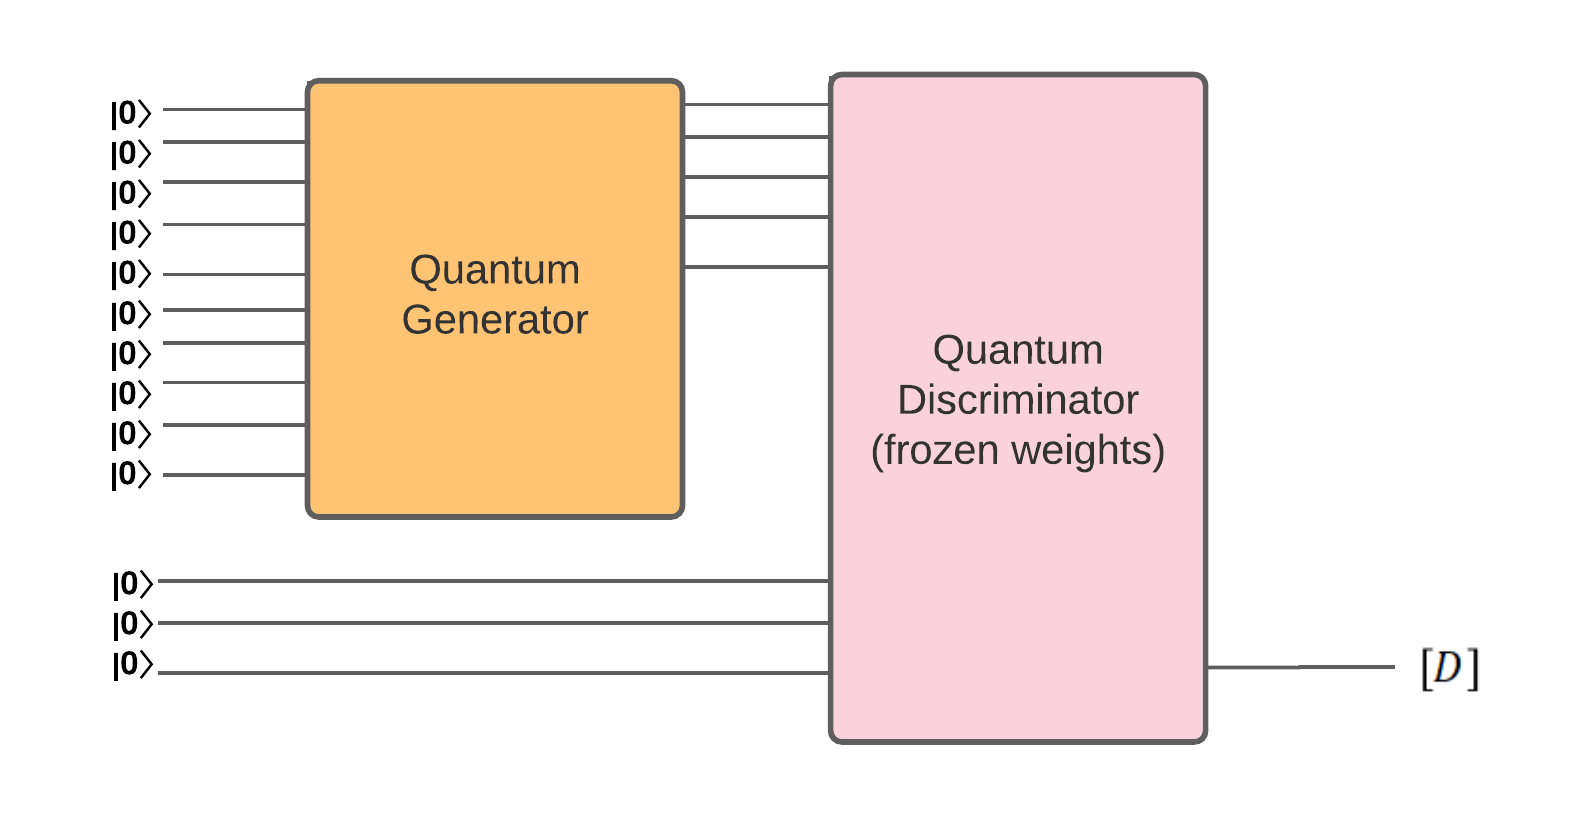

**Figure 3**: Quantum Generator schematic when connected to the discriminator. Notice that we only need the [$D$] output from discriminator during generator training.

During generator training, only weights in the qgen will be trained, while the weights in the qdisc will be frozen as said earlier.

For training the generator, we only care that the generator can fool the discriminator, so we only care for the [$D$] output from the discriminator. The generator training's loss function is as follow:

$$
L_{G}=-\frac{1}{m} \sum_{i=1}^{m} \log \left(D\left(\boldsymbol{x}_{\text {fake }}^{i}\right)\right)
$$

where $m$ is the total number of fake data in the batch, $D$ is the fake/real prediction from the qdisc.

**Note**: when calculating the loss, all qdisc predictions are converted from 1/-1 format into 1/0 format first. So the fake/real prediction output becomes 1 for real and 0 for fake.

## Code Implementation

Below is the code implementation of QGAN training as explained above.

### Load and Check the Dataset

Let's load the dataset.

In [4]:
# Load the dataset
with np.load('./QIS_EXAM_200Events.npz', allow_pickle=True) as data:
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)

y_train = np.zeros((len(x_train),))
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),))
y_test[len(x_test_0):] = 1

# Sanity check
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 5) (100,)
(100, 5) (100,)


Check the minimum and maximum value of the features to see whether we need to scale them or not. Since an RY gate's argument is an angle, it is best to keep the value of the features between $-\pi$ to $\pi$.

In [5]:
# Checking the minimum and maximum value of the features
print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

-0.9999305803064449 0.9344843617214956
-0.9997083749335067 0.934061853011746


The values are all inside the boundary so no need to scale the features.

The next thing to check is the label balances. It turns out that the dataset is perfectly balanced, so no need to do any dataset imbalance preprocessing tricks, e.g., SMOTE.

In [6]:
# Check class balances
print("Class 0:", (y_train == 0).sum(), "Class 1:", (y_train == 1).sum())
print("Class 0:", (y_test == 0).sum(), "Class 1:", (y_test == 1).sum())

Class 0: 50 Class 1: 50
Class 0: 50 Class 1: 50


The last thing to do is to convert the true label to one-hot format but with 1/-1 instead of 1/0. We also need to append the label with the status of the samples, with 1 means real and -1 means fake.

In [7]:
# convert label format from 1/0 to 1/-1
y_train = tf.keras.utils.to_categorical(y_train)*2-1
y_test = tf.keras.utils.to_categorical(y_test)*2-1

y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

print(y_train.shape, y_test.shape)

(100, 3) (100, 3)


### Generate Quantum Data from the Dataset (Angle Encoding)

In [8]:
def generate_data(X, qubits):
    """Generate quantum data from the dataset with angle encoding."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        # iterate through sample's features
        for bit in range(len(sample)):
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))
        
        quantum_data.append(circuit)

    return quantum_data

Let's plot the angle encoding circuit for both label's first sample in the dataset.

In [9]:
qubits = cirq.GridQubit.rect(1, 5)
train_quantum_data = tfq.convert_to_tensor(generate_data(x_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_data(x_test, qubits))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


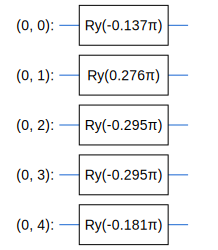

In [10]:
# label 1
SVGCircuit(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==1][0])

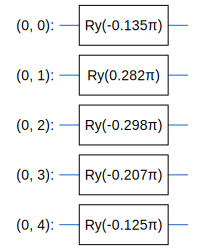

In [11]:
# label -1
SVGCircuit(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==-1][0])

### Define Layers

Next, we need to define all the layers that will be used for the generator and discriminator model.

#### Unitaries

Below are the standard, simple, one and two-qubit unitary circuits. These unitaries are generally very useful as building blocks.

In [12]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

#### QGAN Layers

Below are the functions that will be needed to construct a QGAN model.

##### Quantum Generator Circuit

This circuit is the Quantum Generator block in **Figure 2** and **Figure 3**.

In [13]:
def generator(qubits, symbols, layer=1):
    circuit = cirq.Circuit()

    # Random rotation layer for data qubits
    random_angle = np.random.normal(loc=0, scale=np.pi/3, size=int(len(qubits)/2))
    for i in range(int(len(qubits)/2)):
        circuit += cirq.ry(random_angle[i])(qubits[i])

    for i in range(layer):
        # unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])
        
        # entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # final unitary for data qubits
    symbols_last_unitary = symbols[-(3*int(len(qubits)/2)):]
    for i in range(int(len(qubits)/2)):
        circuit += one_qubit_unitary(qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit

Let's plot the circuit for 2 layer configuration.

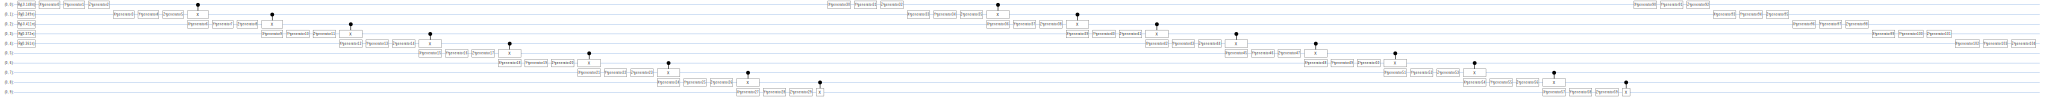

In [14]:
# params total: (3*features*2)*layer params + (3*features) final params
SVGCircuit(generator(cirq.GridQubit.rect(1, 10), sympy.symbols('generator:105'), layer=2))

##### Quantum Discriminator Circuit

This circuit is the Quantum Discriminator block in **Figure 1-3**.

In [15]:
def discriminator(data_qubits, output_qubits, symbols, layer=1):
    circuit = cirq.Circuit()

    # Hadamard layer for data qubits
    for i in range(len(data_qubits)):
        circuit += cirq.H(data_qubits[i])
    
    qubits = data_qubits + output_qubits
    for i in range(layer):
        # unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # final unitary for output qubits
    symbols_last_unitary = symbols[-(3*len(output_qubits)):]
    for i in range(len(output_qubits)):
        circuit += one_qubit_unitary(output_qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit

Let's plot the circuit for 2 layer configuration.

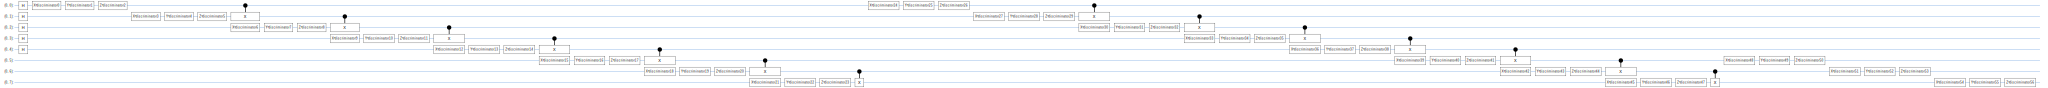

In [16]:
qubits = cirq.GridQubit.rect(1, 5+3)
# params total: (3 * (features + (num_class + 1)))*layer + 3*(num_class + 1) final params
SVGCircuit(discriminator(qubits[0:5], qubits[5:], sympy.symbols('discriminator:57'), layer=2))

##### Quantum Generator + Quantum Discriminator Circuit

This circuit will be used to train the generator. See **Figure 3** for the schematic of this circuit.

In [17]:
def create_gen_disc_circuit(symbols_gen, symbols_disc, qubits, num_features, num_class, gen_layer=1, disc_layer=1):
    gen_disc_circuit = cirq.Circuit()

    # add the generator
    gen_disc_circuit += generator(qubits[:len(qubits)-(num_class+1)], symbols_gen, layer=gen_layer)
    # add the discriminator
    gen_disc_circuit += discriminator(qubits[:int((len(qubits)-(num_class+1))/2)], qubits[len(qubits)-(num_class+1):], symbols_disc, layer=disc_layer)

    return gen_disc_circuit

### Define Model

#### Fix Parameters

Below are all of the fixed model parameters. The total number of qubits needed for this QGAN training is 13 qubits (10 qubits for qgen, 8 qubits for qdisc but the first 5 qubits are overlapping between the two). The number of layers for both qgen and qdisc is 4, following the reference [1].

In [18]:
# model fix parameters
num_class = 2
num_features = 5
gen_layer = 4
disc_layer = 4

total_gen_params = (3*num_features*2)*gen_layer + (3*num_features)
total_disc_params = (3*(num_features + num_class + 1))*disc_layer + 3*(num_class + 1)

print(total_gen_params, total_disc_params)

135 105


In [19]:
# trainable parameters
symbols_gen = sympy.symbols('gen0:' + str(total_gen_params))
symbols_disc = sympy.symbols('disc0:' + str(total_disc_params))

# qubits
qgan_qubits = cirq.GridQubit.rect(1, num_features*2 + num_class + 1)

#### Discriminator Model

Next, we need to construct the discriminator model.

This disc_loss function is the discriminator loss explained in the **The Approach Used to Tackle the Problem** section. We start with $C_{weight}=0.5$ and we will later increase this value.

In [20]:
C_weight = 0.5

@tf.function
def disc_loss(y_true, y_pred):
    D_true = (y_true[:, 2] + 1)/2
    D_pred = (y_pred[:, 2] + 1)/2

    D_loss = -1*(tf.math.log(D_pred + 1e-10)*D_true + tf.math.log(1 - D_pred + 1e-10)*(D_true - 1)*(-1))
    D_loss = tf.reduce_mean(D_loss, axis=0)

    C_true = (y_true[:, :2] + 1)/2
    C_pred = (y_pred[:, :2] + 1)/2

    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    C_loss = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true, C_pred) * D_true)/D_true_size

    return (1-C_weight)*D_loss + C_weight*C_loss

This custom_accuracy function below is to calculate the discriminator accuracy in predicting the class.

In [21]:
# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    D_true = (y_true[:, 2] + 1)/2

    C_real_true = (y_true[:, :2] + 1)/2
    C_real_pred = (y_pred[:, :2] + 1)/2

    C_real_true = tf.math.argmax(C_real_true, axis=1)
    C_real_pred = tf.math.argmax(C_real_pred, axis=1)

    same = tf.cast(C_real_true == C_real_pred, tf.float32)*D_true

    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    return tf.math.reduce_sum(same)/D_true_size

Now let's construct the model. The optimizer that will be used is Adam with lr = 0.001.

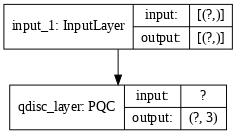

In [22]:
# discriminator model

def discriminator_model(weights_disc):
    disc_readout_operators = [cirq.Z(qgan_qubits[-(num_class+1) + q]) for q in range(num_class+1)]

    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    qdisc_layer = tfq.layers.PQC(discriminator(qgan_qubits[:int((len(qgan_qubits)-(num_class+1))/2)],
                  qgan_qubits[len(qgan_qubits)-(num_class+1):], weights_disc, layer=disc_layer),
                  disc_readout_operators, name='qdisc_layer')(data_input)

    qdisc_model = tf.keras.Model(inputs=[data_input], outputs=[qdisc_layer])

    # Compile the model
    qdisc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=disc_loss,
                   metrics=[custom_accuracy]
                    )
    
    return qdisc_model

qdisc_model = discriminator_model(symbols_disc)

# Show the keras plot of the model
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

#### Generator Model

Next, we need to construct the generator model.

This gen_loss function is the generator loss explained in the **The Approach Used to Tackle the Problem** section. We don't need to calculate the accuracy of the discriminator during generator training.

In [23]:
def gen_loss(y_true, y_pred):
    y_pred = (y_pred + 1)/2
    return tf.reduce_mean((-1)*tf.math.log(y_pred), axis=0)

Now let's construct the model. The optimizer that will be used is Adam with lr = 0.001, same with the discriminator model. The generator model does not need any input. But to conform with the TFQ structure, the input layer will still be used but the content of the circuit is just identity.

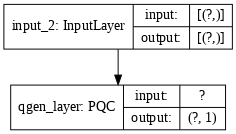

In [24]:
# generator-discriminator pair model

def generator_model(symbols_gen, weights_disc):
    gen_readout_operators = cirq.Z(qgan_qubits[-1])

    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    qgen_layer = tfq.layers.PQC(create_gen_disc_circuit(symbols_gen, weights_disc,
                                  qgan_qubits, num_features, num_class, gen_layer=gen_layer, disc_layer=disc_layer),
                                  gen_readout_operators, name='qgen_layer')(data_input)

    qgen_model = tf.keras.Model(inputs=[data_input], outputs=[qgen_layer])

    # Compile the model
    qgen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=gen_loss)

    return qgen_model

qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

# Show the keras plot of the model
tf.keras.utils.plot_model(qgen_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

Function below will generate identity quantum data to train the generator. The labels of the data is not important and can be anything as long as the length of the labels match the length of the samples generated.

In [25]:
def generate_identity(X):
    """Generate identity quantum data."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        
        quantum_data.append(circuit)

    return quantum_data

In [26]:
identity_data = tfq.convert_to_tensor(generate_identity(x_train))
identity_label = np.zeros((len(identity_data),))

# Sanity check
print(len(identity_data), identity_label.shape)

100 (100,)


Let's check the first sample of the identity data for sanity check (if the data is correct, the print function will print nothing).

In [27]:
print(generate_identity(x_train)[0])

#### Fake Data Generator

This function below will generate fake quantum data using the qgen circuit.

In [28]:
def generate_fake_data(X, qubits, symbols, layer=1):
    """Generate fake quantum data."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        # the argument X (samples) is only used to count how many fake samples
        # to be generated, it is not used for any other things
        circuit = generator(qubits[:2*len(sample)], symbols, layer=layer)
        
        quantum_data.append(circuit)

    return quantum_data

After creating the fake quantum data, we also need to create the labels for that fake data. These labels can be created just as an array of zeros for the class labels since the class labels are not important for fake data. All of the samples will get -1 for the fake/real label since they are all fake.

In [29]:
fake_data = tfq.convert_to_tensor(generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
y_true_fake = np.zeros((len(fake_data), num_class+1))
y_true_fake[:, 2] += (-1)

y_true_fake.shape

(100, 3)

Let's plot the fake quantum data circuit for the first two samples generated.

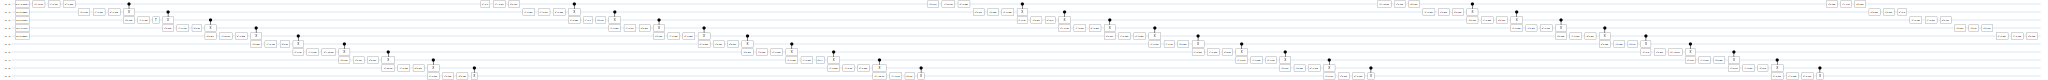

In [30]:
SVGCircuit(tfq.from_tensor(fake_data)[0])

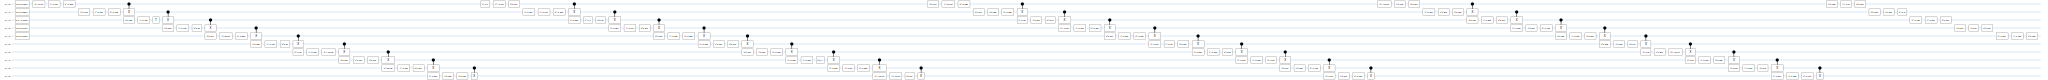

In [31]:
SVGCircuit(tfq.from_tensor(fake_data)[1])

### Train the Model

Now we are ready to start the model training.

#### Initialization

Initialize both the discriminator and generator model.

In [32]:
# Model initialization
qdisc_model = discriminator_model(symbols_disc)
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

Below is the checkpoint function to save the model weights.

In [ ]:
def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_generator_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_disc_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='custom_accuracy',
        mode='max',
        save_best_only=True)
    
    return gen_model_cp, disc_model_cp

Below are the functions to start training the generator and the discriminator.

In [ ]:
def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    history = qgen_model.fit(x=identity_data,
                            y=identity_label,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[gen_model_cp])
    
    return history

In [ ]:
def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(x=gen_data_train,
                            y=y_gen_train,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[disc_model_cp],
                            validation_data=(gen_data_test, y_gen_test)
                            )
    return history

#### Adversarial Game

Let's start the adversarial game, i.e., the process of training the generator and discriminator (one at a time) in turns until we obtain the model that we wanted (in this case, a discriminator that is good in classifying the real data).

##### First Cycle

Let's always start the cycle by copying both of the models' weights into new variables just in case.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

Declare the checkpoint function with the correct number of cycle.

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=1)

At every cycle, we train the generator first. Let's start with 1000 epochs with 100 batch size (1 parameter update/epoch).

In [ ]:
# Fit the Generator Model
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 1s 615ms/step - loss: 0.6941
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6917
Epoch 3/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.6894
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.6871
Epoch 5/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6848
Epoch 6/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.6825
Epoch 7/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6802
Epoch 8/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6780
Epoch 9/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6757
Epoch 10/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6735
Epoch 11/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6713
Epoch 12/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6692
Epoch 13/1000
1/1 [=================

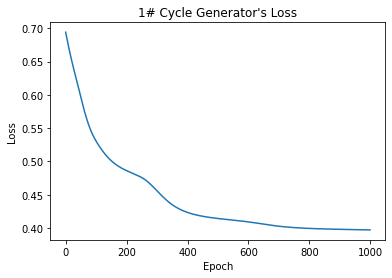

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Generator's Loss")
plt.show()

We can see that the loss value is reduced during the training, the generator successfully fools the discriminator.

After that, let's generate the fake quantum data for discriminator training using the trained generator weights. This fake quantum data will be mixed with real quantum data and the discriminator will be trained by using both data.

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


For the discriminator, let's start with 200 epochs with 64 batch size (4 parameter update/epoch).

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(200, 64, 1)

Epoch 1/200
4/4 [==============================] - 3s 677ms/step - loss: 0.6908 - custom_accuracy: 0.7315 - val_loss: 0.5622 - val_custom_accuracy: 0.3520
Epoch 2/200
4/4 [==============================] - 2s 499ms/step - loss: 0.6866 - custom_accuracy: 0.6708 - val_loss: 0.5591 - val_custom_accuracy: 0.3559
Epoch 3/200
4/4 [==============================] - 2s 495ms/step - loss: 0.6826 - custom_accuracy: 0.6815 - val_loss: 0.5560 - val_custom_accuracy: 0.3559
Epoch 4/200
4/4 [==============================] - 2s 485ms/step - loss: 0.6788 - custom_accuracy: 0.6902 - val_loss: 0.5534 - val_custom_accuracy: 0.3715
Epoch 5/200
4/4 [==============================] - 2s 562ms/step - loss: 0.6746 - custom_accuracy: 0.7992 - val_loss: 0.5505 - val_custom_accuracy: 0.3572
Epoch 6/200
4/4 [==============================] - 2s 494ms/step - loss: 0.6711 - custom_accuracy: 0.7857 - val_loss: 0.5476 - val_custom_accuracy: 0.3442
Epoch 7/200
4/4 [==============================] - 2s 507ms/step - los

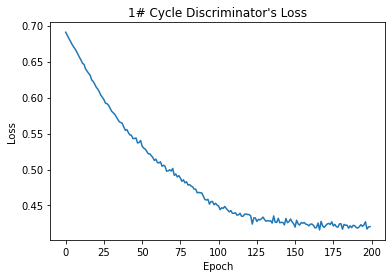

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Discriminator's Loss")
plt.show()

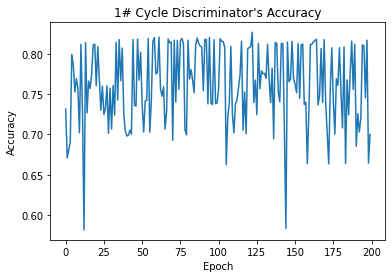

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("1# Cycle Discriminator's Accuracy")
plt.show()

We can see that the discriminator learned to both classify the data and determine whether the data is fake/real as the loss value kept getting lowered during the training. The training accuracy fluctuated a lot because the model needs to do both tasks at the same time. Sometimes it prioritized the real/fake prediction task as both tasks contribute the same percentage to the total loss value.

The validation accuracy shown in the output of the training process is not accurate. Until the time of submission, it is still not known why. We will get this value below if we calculate the model's accuracy using the testing dataset manually.

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

The first cycle is done and let's continue with the next cycle.

##### Second Cycle

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

Let's train the generator for the second time.

In [ ]:
# Fit the Generator Model
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 1s 631ms/step - loss: 0.6567
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6469
Epoch 3/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6373
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6280
Epoch 5/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6189
Epoch 6/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6101
Epoch 7/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6016
Epoch 8/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.5933
Epoch 9/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5853
Epoch 10/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.5775
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.5699
Epoch 12/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5626
Epoch 13/1000
1/1 [=================

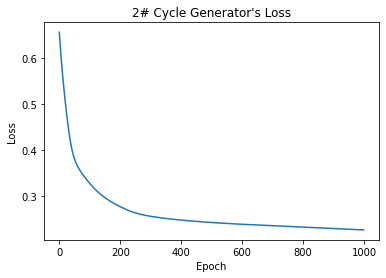

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Generator's Loss")
plt.show()

The generator's loss gets even lower than the #1 cycle, indicating that it becomes better at fooling the discriminator.

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


To even the game, we now need to train the discriminator. Since the generator's loss is lower than previous cycle, the discriminator needs to be trained longer, so we will increase the epochs to 250.

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

Epoch 1/250
4/4 [==============================] - 3s 703ms/step - loss: 0.4591 - custom_accuracy: 0.7036 - val_loss: 0.3890 - val_custom_accuracy: 0.3442
Epoch 2/250
4/4 [==============================] - 2s 538ms/step - loss: 0.4615 - custom_accuracy: 0.7555 - val_loss: 0.3881 - val_custom_accuracy: 0.3442
Epoch 3/250
4/4 [==============================] - 2s 535ms/step - loss: 0.4595 - custom_accuracy: 0.7031 - val_loss: 0.3876 - val_custom_accuracy: 0.3442
Epoch 4/250
4/4 [==============================] - 2s 525ms/step - loss: 0.4577 - custom_accuracy: 0.7018 - val_loss: 0.3871 - val_custom_accuracy: 0.3442
Epoch 5/250
4/4 [==============================] - 2s 521ms/step - loss: 0.4596 - custom_accuracy: 0.7686 - val_loss: 0.3862 - val_custom_accuracy: 0.3442
Epoch 6/250
4/4 [==============================] - 2s 509ms/step - loss: 0.4580 - custom_accuracy: 0.7683 - val_loss: 0.3851 - val_custom_accuracy: 0.3442
Epoch 7/250
4/4 [==============================] - 2s 517ms/step - los

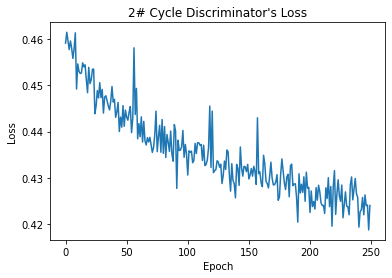

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Discriminator's Loss")
plt.show()

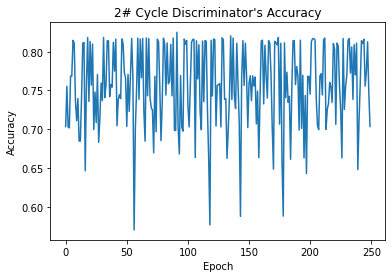

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("2# Cycle Discriminator's Accuracy")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

##### Third Cycle

Now the discriminator needs to start focusing more on the class prediction task. We will change the $C_{weight}$ to 0.8.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=3)

Since we want to focus more on the class prediction task, the role of the generator is not too important now. We will reduce the number of epochs to 500.

In [ ]:
# Fit the Generator Model
H = train_qgen(500, 100, 1)

Epoch 1/500
1/1 [==============================] - 1s 535ms/step - loss: 0.7683
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 0.7610
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 0.7538
Epoch 4/500
1/1 [==============================] - 0s 13ms/step - loss: 0.7465
Epoch 5/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7393
Epoch 6/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7321
Epoch 7/500
1/1 [==============================] - 0s 37ms/step - loss: 0.7250
Epoch 8/500
1/1 [==============================] - 0s 33ms/step - loss: 0.7181
Epoch 9/500
1/1 [==============================] - 0s 15ms/step - loss: 0.7112
Epoch 10/500
1/1 [==============================] - 0s 12ms/step - loss: 0.7044
Epoch 11/500
1/1 [==============================] - 0s 16ms/step - loss: 0.6978
Epoch 12/500
1/1 [==============================] - 0s 14ms/step - loss: 0.6913
Epoch 13/500
1/1 [==============================

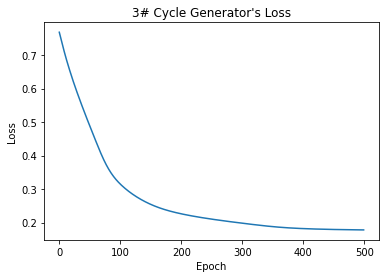

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.8

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

Epoch 1/250
4/4 [==============================] - 3s 706ms/step - loss: 0.4441 - custom_accuracy: 0.8227 - val_loss: 0.3818 - val_custom_accuracy: 0.3442
Epoch 2/250
4/4 [==============================] - 2s 502ms/step - loss: 0.4500 - custom_accuracy: 0.7572 - val_loss: 0.3810 - val_custom_accuracy: 0.3442
Epoch 3/250
4/4 [==============================] - 2s 509ms/step - loss: 0.4505 - custom_accuracy: 0.7547 - val_loss: 0.3795 - val_custom_accuracy: 0.3442
Epoch 4/250
4/4 [==============================] - 2s 510ms/step - loss: 0.4460 - custom_accuracy: 0.7022 - val_loss: 0.3777 - val_custom_accuracy: 0.3442
Epoch 5/250
4/4 [==============================] - 2s 480ms/step - loss: 0.4534 - custom_accuracy: 0.7155 - val_loss: 0.3756 - val_custom_accuracy: 0.3442
Epoch 6/250
4/4 [==============================] - 2s 517ms/step - loss: 0.4426 - custom_accuracy: 0.8126 - val_loss: 0.3741 - val_custom_accuracy: 0.3442
Epoch 7/250
4/4 [==============================] - 2s 496ms/step - los

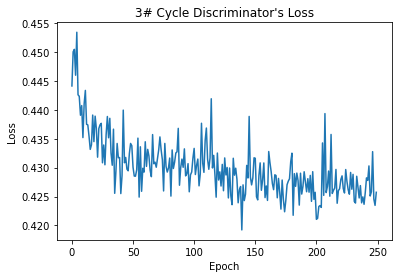

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3# Cycle Discriminator's Loss")
plt.show()

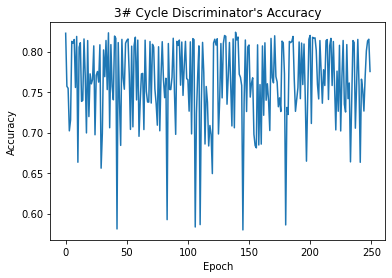

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("3# Cycle Discriminator's Accuracy")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

##### Forth Cycle

Now we will focus 95% with the class prediction task, $C_{weight}=0.95$.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=4)

We will also reduce the number of epochs for generator training further down to just 150.

In [ ]:
# Fit the Generator Model
H = train_qgen(150, 100, 1)

Epoch 1/150
1/1 [==============================] - 1s 701ms/step - loss: 0.6633
Epoch 2/150
1/1 [==============================] - 0s 14ms/step - loss: 0.6549
Epoch 3/150
1/1 [==============================] - 0s 17ms/step - loss: 0.6468
Epoch 4/150
1/1 [==============================] - 0s 16ms/step - loss: 0.6389
Epoch 5/150
1/1 [==============================] - 0s 17ms/step - loss: 0.6311
Epoch 6/150
1/1 [==============================] - 0s 14ms/step - loss: 0.6236
Epoch 7/150
1/1 [==============================] - 0s 15ms/step - loss: 0.6162
Epoch 8/150
1/1 [==============================] - 0s 16ms/step - loss: 0.6090
Epoch 9/150
1/1 [==============================] - 0s 12ms/step - loss: 0.6019
Epoch 10/150
1/1 [==============================] - 0s 27ms/step - loss: 0.5949
Epoch 11/150
1/1 [==============================] - 0s 13ms/step - loss: 0.5881
Epoch 12/150
1/1 [==============================] - 0s 12ms/step - loss: 0.5813
Epoch 13/150
1/1 [==============================

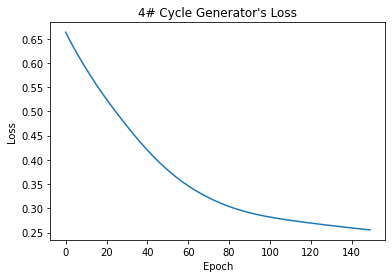

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("4# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.95

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

Epoch 1/250
4/4 [==============================] - 3s 661ms/step - loss: 0.4294 - custom_accuracy: 0.7733 - val_loss: 0.3632 - val_custom_accuracy: 0.3442
Epoch 2/250
4/4 [==============================] - 2s 492ms/step - loss: 0.4330 - custom_accuracy: 0.7803 - val_loss: 0.3629 - val_custom_accuracy: 0.3442
Epoch 3/250
4/4 [==============================] - 2s 492ms/step - loss: 0.4343 - custom_accuracy: 0.7668 - val_loss: 0.3625 - val_custom_accuracy: 0.3442
Epoch 4/250
4/4 [==============================] - 2s 495ms/step - loss: 0.4281 - custom_accuracy: 0.8167 - val_loss: 0.3624 - val_custom_accuracy: 0.3442
Epoch 5/250
4/4 [==============================] - 2s 497ms/step - loss: 0.4337 - custom_accuracy: 0.7544 - val_loss: 0.3624 - val_custom_accuracy: 0.3442
Epoch 6/250
4/4 [==============================] - 2s 505ms/step - loss: 0.4298 - custom_accuracy: 0.7408 - val_loss: 0.3621 - val_custom_accuracy: 0.3442
Epoch 7/250
4/4 [==============================] - 2s 499ms/step - los

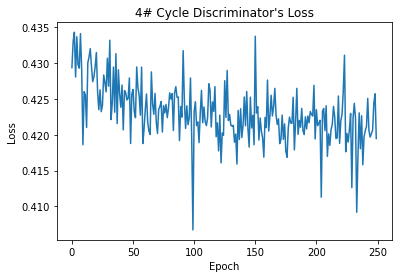

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("4# Cycle Discriminator's Loss")
plt.show()

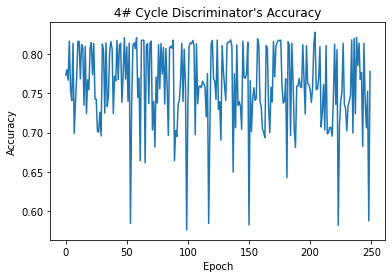

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("4# Cycle Discriminator's Accuracy")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

##### Fifth Cycle

We will 100% focus on the class prediction task for the last cycle, $C_{weight}=1.0$. Since the $L_{D}$ loss will no longer matter, we will train the discriminator purely on real quantum data.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=5)

In [ ]:
C_weight = 1.0

In [ ]:
# Fit the Discriminator Model
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=32,
                          epochs=250,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

Epoch 1/250
4/4 [==============================] - 1s 262ms/step - loss: 0.3016 - custom_accuracy: 0.7578 - val_loss: 0.3284 - val_custom_accuracy: 0.7734
Epoch 2/250
4/4 [==============================] - 1s 141ms/step - loss: 0.3004 - custom_accuracy: 0.7031 - val_loss: 0.3268 - val_custom_accuracy: 0.7734
Epoch 3/250
4/4 [==============================] - 1s 137ms/step - loss: 0.2986 - custom_accuracy: 0.7578 - val_loss: 0.3252 - val_custom_accuracy: 0.7734
Epoch 4/250
4/4 [==============================] - 1s 142ms/step - loss: 0.2969 - custom_accuracy: 0.7578 - val_loss: 0.3239 - val_custom_accuracy: 0.7734
Epoch 5/250
4/4 [==============================] - 1s 142ms/step - loss: 0.2954 - custom_accuracy: 0.7578 - val_loss: 0.3229 - val_custom_accuracy: 0.7734
Epoch 6/250
4/4 [==============================] - 1s 147ms/step - loss: 0.2940 - custom_accuracy: 0.7031 - val_loss: 0.3218 - val_custom_accuracy: 0.7734
Epoch 7/250
4/4 [==============================] - 1s 146ms/step - los

In [ ]:
# Fit the Discriminator Model for another 250 epochs
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=32,
                          epochs=250,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

Epoch 1/250
4/4 [==============================] - 1s 167ms/step - loss: 0.2808 - custom_accuracy: 0.7578 - val_loss: 0.3102 - val_custom_accuracy: 0.7734
Epoch 2/250
4/4 [==============================] - 1s 164ms/step - loss: 0.2807 - custom_accuracy: 0.8125 - val_loss: 0.3108 - val_custom_accuracy: 0.7734
Epoch 3/250
4/4 [==============================] - 1s 168ms/step - loss: 0.2808 - custom_accuracy: 0.7578 - val_loss: 0.3112 - val_custom_accuracy: 0.7734
Epoch 4/250
4/4 [==============================] - 1s 165ms/step - loss: 0.2808 - custom_accuracy: 0.8125 - val_loss: 0.3118 - val_custom_accuracy: 0.7734
Epoch 5/250
4/4 [==============================] - 1s 160ms/step - loss: 0.2808 - custom_accuracy: 0.6484 - val_loss: 0.3123 - val_custom_accuracy: 0.7734
Epoch 6/250
4/4 [==============================] - 1s 150ms/step - loss: 0.2808 - custom_accuracy: 0.8125 - val_loss: 0.3120 - val_custom_accuracy: 0.7734
Epoch 7/250
4/4 [==============================] - 1s 137ms/step - los

In [ ]:
# Fit the Discriminator Model for another 500 epochs
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=32,
                          epochs=500,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

Epoch 1/500
4/4 [==============================] - 1s 138ms/step - loss: 0.2785 - custom_accuracy: 0.8125 - val_loss: 0.3058 - val_custom_accuracy: 0.7734
Epoch 2/500
4/4 [==============================] - 1s 141ms/step - loss: 0.2783 - custom_accuracy: 0.7031 - val_loss: 0.3060 - val_custom_accuracy: 0.7734
Epoch 3/500
4/4 [==============================] - 1s 139ms/step - loss: 0.2783 - custom_accuracy: 0.8125 - val_loss: 0.3062 - val_custom_accuracy: 0.7734
Epoch 4/500
4/4 [==============================] - 1s 137ms/step - loss: 0.2783 - custom_accuracy: 0.7578 - val_loss: 0.3064 - val_custom_accuracy: 0.7734
Epoch 5/500
4/4 [==============================] - 1s 140ms/step - loss: 0.2782 - custom_accuracy: 0.8125 - val_loss: 0.3065 - val_custom_accuracy: 0.7734
Epoch 6/500
4/4 [==============================] - 1s 138ms/step - loss: 0.2783 - custom_accuracy: 0.7031 - val_loss: 0.3068 - val_custom_accuracy: 0.7734
Epoch 7/500
4/4 [==============================] - 1s 137ms/step - los

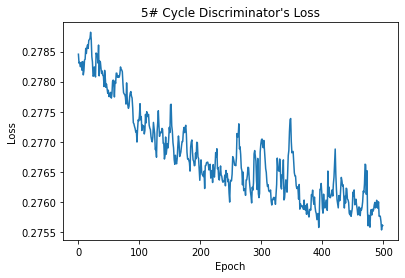

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("5# Cycle Discriminator's Loss")
plt.show()

##### Final Result

After tuning the parameters here and there and restarting the whole process with different parameters (the ones that stay in the notebook are the best so far), these final models are obtained.

In [ ]:
qdisc_model.save_weights('./model_save/disc_final.h5')
qgen_model.save_weights('./model_save/gen_final.h5')

In [33]:
qdisc_model.load_weights('./model_save/disc_final.h5')

The final model of the discriminator gives 0.8 training accuracy and 0.72 testing accuracy, and 0.854 training AUC and 0.784 testing AUC. There is quite a big difference between the two accuracies (and AUC scores), a sign of overfitting. This is to be expected since the training dataset is too small. The generator helps, but it seems the discriminator still needs more real training data.

In [53]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

Training Accuracy: 0.8
Testing Accuracy 0.72
Training AUC: 0.8544
Testing AUC: 0.7844


## Conclusion

A QGAN architecture is proposed and trained in this project. At the end of the training process, the discriminator obtained 0.8 training accuracy and 0.72 testing accuracy, and 0.854 training AUC and 0.784 testing AUC. Choosing the right parameters and controlling the adversarial game are the hardest part of training a QGAN model since there are many moving parts in a QGAN architecture. In the future, testing a new ansatz for both the generator and discriminator may bring better performance as the ansatz is fixed in this project.

## References

1. [K. Nakaji and N. Yamamoto, “Quantum semi-supervised generative adversarial network for enhanced data classification,” Oct. 2020.](https://arxiv.org/abs/2010.13727)
2. [P. L. Dallaire-Demers and N. Killoran, “Quantum generative adversarial networks,” Phys. Rev. A, vol. 98, no. 1, p. 012324, Jul. 2018.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324)